In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics.regression import mean_squared_error
%matplotlib inline

In [195]:
class GaussianDensity(object):
    def __init__(self, h=1, model=None):
        self.h = h
        self.model = model or LinearRegression()
        self.X = None
        
    def fit(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        self.X = X
        G = sp.stats.norm.pdf(euclidean_distances(X, X)/self.h)
        self.model.fit(G.T.dot(G)+np.eye(G.shape[1])*1e-9, G.T.dot(y))
        return self
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        G = sp.stats.norm.pdf(euclidean_distances(X, self.X)/self.h)
        return self.model.predict(G)
    
    def score(self, X, y):
        return -mean_squared_error(self.predict(X), y)
    
    def get_params(self, deep=True):
        return {"h": self.h}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
class GaussianDensityMultiH(object):
    def __init__(self, hs=[1], kernel=rbf_kernel, model=None):
        self.hs = hs
        self.kernel_ = kernel
        self.model = model or LinearRegression()
        self.X = None
        
    def fit(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        self.X = X
        G = np.hstack([sp.stats.norm.pdf(euclidean_distances(X, X)/h) for h in self.hs])
        self.model.fit(G.T.dot(G), G.T.dot(y))
        return self
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(X.size, 1)
        G = np.hstack([sp.stats.norm.pdf(euclidean_distances(X, self.X)/h) for h in self.hs])
        return self.model.predict(G)
    
    def score(self, X, y):
        return -mean_squared_error(self.predict(X), y)
    
    def get_params(self, deep=True):
        return {"h": self.h}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [166]:
from sklearn.kernel_ridge import KernelRidge

fl = pd.read_csv('./data/Locations.txt', sep=' ')
fm = pd.read_csv('./data/Oregon_Met_Data.txt', sep=' ')

def mean_temperature(sid, fm=fm):
    possible = np.logical_and(fm.SID.as_matrix() == sid, fm.Tmin_deg_C.as_matrix() < 999)
    X1 = fm.Time.as_matrix()[possible]
    X1 = X1.reshape((X1.size,1))
    Y1 = fm.Tmin_deg_C.as_matrix()[possible]
    days = np.arange(1, fm.Time.max()+1)
    days = days.reshape((days.size, 1))
    return np.mean(KernelRidge(kernel='rbf', gamma=1).fit(X1, Y1).predict(days))

def mean_temperature2(sid, fm=fm):
    possible = np.logical_and(fm.SID.as_matrix() == sid, fm.Tmin_deg_C.as_matrix() < 999)
    Y = fm.Tmin_deg_C.as_matrix()[possible]
    return np.mean(Y)
    
# the position of the all the 
positions = np.vstack([fl.East_UTM.as_matrix(), fl.North_UTM.as_matrix()]).T
temps = np.array([mean_temperature2(i) for i in range(fm.SID.min(), fm.SID.max()+1)])
long, lat = np.meshgrid(
    np.linspace(fl.East_UTM.min()-1, fl.East_UTM.max()+1, 100),
    np.linspace(fl.North_UTM.min()-1, fl.North_UTM.max()+1, 100))
    
grid = np.vstack([long.ravel(), lat.ravel()]).T

the mean distance between two point is 126738.925065


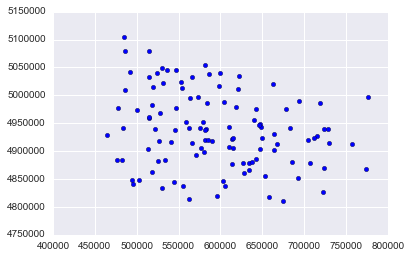

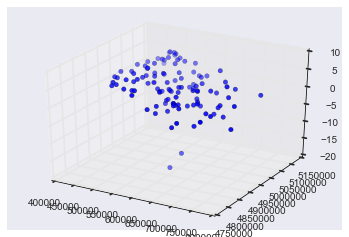

In [163]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(1)
plt.scatter(x=positions[:,0], y=positions[:,1])
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], temps)
print("the mean distance between two point is %f"%(np.mean(euclidean_distances(positions, positions))))

<a list of 12 text.Text objects>

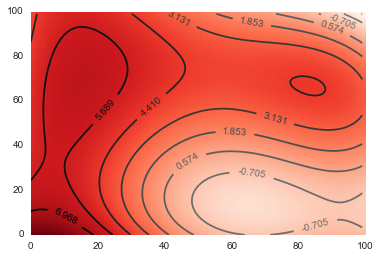

In [179]:
from sklearn.grid_search import GridSearchCV
linear = GaussianDensity()
gs = GridSearchCV(linear, {'h': 126738*1.2**np.arange(-5, 5, 0.3)}, refit=True);
gs.fit(positions, temps)
temresult = gs.predict(grid).reshape((100, 100))
plt.pcolor(temresult,cmap=plt.cm.Reds)
cs = plt.contour(temresult, levels=np.linspace(np.min(temps), np.max(temps), 20)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

(202176.65490871257, 2.9838267639008187)


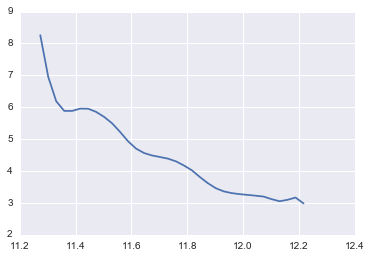

In [176]:
from sklearn.cross_validation import train_test_split
trainx, testx, trainy, testy = train_test_split(positions, temps)
hs = 126738*1.1**np.arange(-5, 5, 0.3)
e = np.zeros(hs.shape)
for i,h in enumerate(hs):
    e[i] = mean_squared_error(GaussianDensity(h=h).fit(trainx, trainy).predict(testx), testy)

print((hs[np.argmin(e)], np.min(e)))
plt.plot(np.log(hs), e)
    

lowest EMS = 8.728745
chosen h = 293184.212975


<a list of 5 text.Text objects>

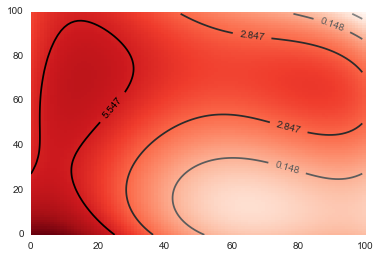

In [180]:
print("lowest EMS = %f"%(-gs.best_score_))
print("chosen h = %f"%(gs.best_params_['h']))
temresult = gs.predict(grid).reshape((100, 100))
plt.pcolor(temresult,cmap=plt.cm.Reds)
cs = plt.contour(temresult, levels=np.linspace(np.min(temps), np.max(temps), 10)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

In [248]:
hs = 126738*1.1**np.arange(-2, 2, 0.3)
lasso = LassoCV(max_iter=15000, alphas=np.logspace(-8, -2, 10))
gs = GaussianDensityMultiH(model=lasso, hs=hs)
gs.fit(positions, temps)

In [246]:
print("number of para used %f", np.sum(lasso.coef_!=0))
print("number of para not used %f", np.sum(lasso.coef_==0))

number of para used %f 1529


best EMS = 7.343894
alpha used = 0.000000
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 7.343842
alpha used = 0.000000
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 7.343599
alpha used = 0.000000
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 7.342475
alpha used = 0.000001
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 7.337098
alpha used = 0.000005
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 7.107461
alpha used = 0.000022
number of parameter used = 285.000000
number of parameter unused = 191.000000
best EMS = 7.150061
alpha used = 0.000100
number of parameter used = 51.000000
number of parameter unused = 425.000000
best EMS = 7.281670
alpha used = 0.000464
number of parameter used = 42.000000
number of parameter unused = 434.000000
best EMS = 7.704489
alpha used = 0.002154
number of 

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


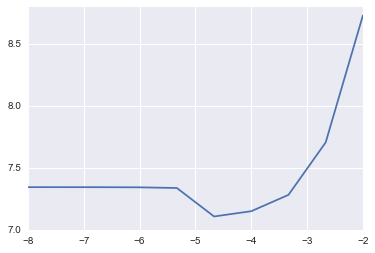

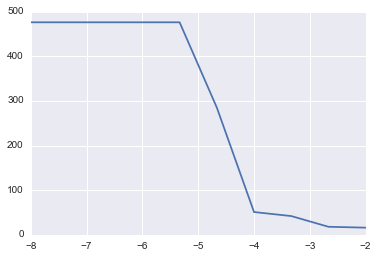

In [244]:
trainx, testx, trainy, testy = train_test_split(positions, temps, test_size=0.3)
alphas=np.logspace(-8, -2, 10)
e = np.zeros(alphas.shape)
n = np.zeros(alphas.shape)
for (i, alpha) in enumerate(alphas):
    lasso = Lasso(alpha=alpha, max_iter=15000)
    gs = GaussianDensityMultiH(model=lasso, hs=hs)
    gs.fit(testx, testy)
    e[i] = mean_squared_error(gs.predict(testx), testy)
    n[i] = np.sum(lasso.coef_!=0)
    print("best EMS = %f"%(mean_squared_error(gs.predict(testx), testy)))
    print("alpha used = %f"%(lasso.alpha))
    print("number of parameter used = %f"%(np.sum(lasso.coef_!=0)))
    print("number of parameter unused = %f"%(np.sum(lasso.coef_==0)))
plt.figure()
plt.plot(np.log10(alphas), e)
plt.figure()
plt.plot(np.log10(alphas), n)

In [205]:
hs = 126738*1.1**np.arange(-2, 2, 0.3)
elastic = ElasticNetCV(max_iter=15000, alphas=np.logspace(-4, 4, 10), l1_ratio=np.array(np.linspace(0, 1, 4)))
gs = GaussianDensityMultiH(model=lasso, hs=hs)
gs.fit(positions, temps)

best EMS = -8.395952
number of parameter used = 13.000000
number of parameter unused = 463.000000


<a list of 8 text.Text objects>

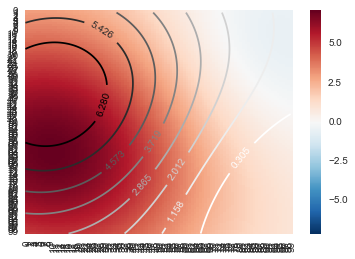

In [231]:
print("best EMS = %f"%(gs.score(positions, temps)))
print("number of parameter used = %f"%(np.sum(lasso.coef_!=0)))
print("number of parameter unused = %f"%(np.sum(lasso.coef_==0)))
temresult = gs.predict(grid).reshape((100, 100))
sns.heatmap(temresult)
cs = plt.contour(temresult, levels=np.linspace(np.min(temresult), np.max(temresult), 10)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)

best EMS = 1.742196
number of parameter used = 476.000000
number of parameter unused = 0.000000
best EMS = 1.745594

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)



number of parameter used = 394.000000
number of parameter unused = 82.000000
best EMS = 1.752892
number of parameter used = 322.000000
number of parameter unused = 154.000000
best EMS = 1.761369
number of parameter used = 264.000000
number of parameter unused = 212.000000
best EMS = 1.767881
number of parameter used = 208.000000
number of parameter unused = 268.000000
best EMS = 1.773809
number of parameter used = 166.000000
number of parameter unused = 310.000000
best EMS = 1.779422
number of parameter used = 136.000000
number of parameter unused = 340.000000
best EMS = 1.788954
number of parameter used = 110.000000
number of parameter unused = 366.000000
best EMS = 1.800337
number of parameter used = 85.000000
number of parameter unused = 391.000000
best EMS = 1.783758
number of parameter used = 105.000000
number of parameter unused = 371.000000


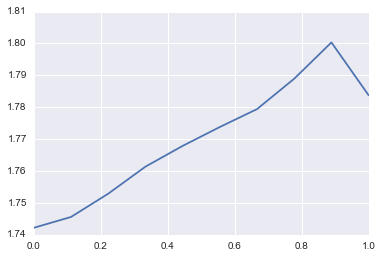

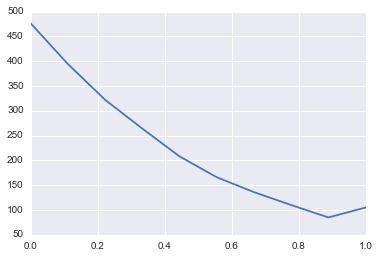

In [296]:
from sklearn.linear_model import ElasticNet
trainx, testx, trainy, testy = train_test_split(positions, temps, test_size=0.3)
l1_ratios=np.linspace(0, 1, 10)
e = np.zeros(alphas.shape)
n = np.zeros(alphas.shape)
for (i, l1_ratio) in enumerate(l1_ratios):
    elastic = ElasticNet(alpha=1e-4, l1_ratio=l1_ratio, max_iter=15000)
    gs = GaussianDensityMultiH(model=elastic, hs=hs)
    gs.fit(testx, testy)
    e[i] = mean_squared_error(gs.predict(testx), testy)
    n[i] = np.sum(elastic.coef_!=0)
    print("best EMS = %f"%(mean_squared_error(gs.predict(testx), testy)))
    print("number of parameter used = %f"%(np.sum(elastic.coef_!=0)))
    print("number of parameter unused = %f"%(np.sum(elastic.coef_==0)))
plt.figure()
plt.plot(l1_ratios, e)
plt.figure()
plt.plot(l1_ratios, n)

In [ ]:
hs = 126738*1.1**np.arange(-2, 2, 0.3)
elastic = ElasticNetCV(verbose=3, max_iter=15000, alphas=np.logspace(-7, -3, 5), l1_ratio=np.array(np.linspace(0.1, 0.9, 4)))
gs = GaussianDensityMultiH(model=elastic, hs=hs)
gs.fit(positions, temps)

<a list of 31 text.Text objects>

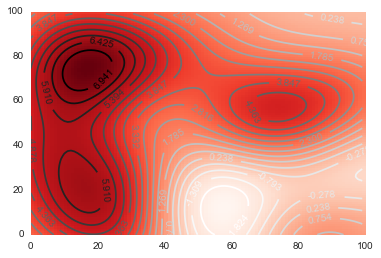

In [288]:
temresult = gs.predict(grid).reshape((100, 100))
plt.pcolor(temresult,cmap=plt.cm.Reds)
cs = plt.contour(temresult, levels=np.linspace(np.min(temresult), np.max(temresult), 20)[1:-1])
plt.clabel(cs, inline=1, fontsize=10)